# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Soham.Dutta\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('C:/Users/Soham.Dutta/AAIC/Amazon reviews/assignment/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 Limit 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [188]:
with open('final.pkl', 'rb') as f:
    final=pickle.load(f)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [19]:
with open('final.pkl', 'wb') as f:
    pickle.dump(final, f)
    

In [36]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [29]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [30]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [31]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [32]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [33]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [34]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [35]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [36]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [37]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:33<00:00, 2594.34it/s]


In [46]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [38]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


In [1]:
len(count_vect.get_feature_names())

NameError: name 'count_vect' is not defined

In [48]:
with open('Bagofwords.pkl', 'wb') as f:
    pickle.dump(final_counts, f)
with open('count_vect.pkl', 'wb') as f:
    pickle.dump(count_vect, f)
    
    

## [4.2] Bi-Grams and n-Grams.

In [39]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [40]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


In [41]:
with open('TFIDF.pkl', 'wb') as f:
    pickle.dump(final_tf_idf, f)
    pickle.dump(tf_idf_vect,f)



In [168]:
features_tfidf=tf_idf_vect.get_feature_names()

## [4.4] Word2Vec

In [200]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [202]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8454307317733765), ('good', 0.8405510187149048), ('awesome', 0.8203623294830322), ('terrific', 0.813459575176239), ('excellent', 0.8025909066200256), ('wonderful', 0.7753733396530151), ('perfect', 0.7702675461769104), ('amazing', 0.7632644772529602), ('nice', 0.7107855081558228), ('fabulous', 0.6965874433517456)]
[('greatest', 0.8440794944763184), ('tastiest', 0.7780045866966248), ('best', 0.7207282781600952), ('nastiest', 0.7097166776657104), ('disgusting', 0.6615241765975952), ('closest', 0.6239991188049316), ('smoothest', 0.6172146201133728), ('hottest', 0.6131520867347717), ('awful', 0.6094019412994385), ('experienced', 0.607596218585968)]


In [203]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [27]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 87773/87773 [03:27<00:00, 422.27it/s]


87773
50


In [32]:
with open('AVGW2V.pkl', 'wb') as f:
    pickle.dump(sent_vectors, f)
    

#### [4.4.1.2] TFIDF weighted W2v

In [198]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [204]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 87773/87773 [39:20<00:00, 37.19it/s]  


In [205]:
with open('TFIDFWV.pkl', 'wb') as f:
    pickle.dump(tfidf_sent_vectors, f)
    

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [1]:
# Please write all the code with proper documentation
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
import math
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from prettytable import PrettyTable
import pylab

C:\Users\Soham.Dutta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Soham.Dutta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
with open('final.pkl', 'rb') as f:
    final=pickle.load(f)

In [21]:
with open('Bagofwords.pkl', 'rb') as f:
    final_counts=pickle.load(f)



In [6]:
with open('count_vect.pkl', 'rb') as f:
    count_vect=pickle.load(f)
    

In [42]:
X=(final_counts)

y=np.array(final["Score"]) #making the score column of dataframe to numpy array
type(X)

scipy.sparse.csr.csr_matrix

First we do the train test split find the hyperparameter which gives us the highest AUC score 


Auc Score of train data for C = 0 is 50%

Auc Score of train data for C = 0 is 74%

Auc Score of train data for C = 1 is 99%

Auc Score of train data for C = 100 is 99%

Auc Score of train data for C = 10000 is 99%


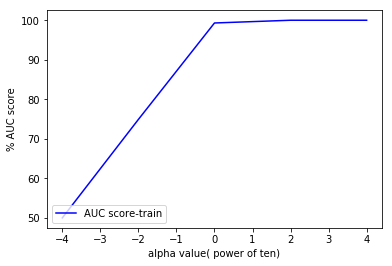

In [39]:


#spliting the test,train,cross-validation data 
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
auc_sc_train=[]
val_C=[]
a=(math.pow(10,-4))
val=-4
for i in range(0,5):
    val_C.append(val)
    LR=LogisticRegression(penalty='l1',C=a)
    LR.fit(X_tr,y_tr)
    train_pred=LR.predict_proba(X_tr)
    auc_train=roc_auc_score(y_tr, train_pred[:,1])* float(100)
    auc_sc_train.append(auc_train)
    print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
    a=a*100
    val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.xlabel("alpha value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()



So from the Graph above we can see that as lambda decreases(C increases) AUC scores increases and the max auc score is 99 % at value of C=1 
but we cannot come to any conclusion from this.

Now we use the cross validaton method to find the optimal hypermater 


Auc Score of train data for C = 0 is 50%

Auc Score of validation data for C= 0 is 50%

Auc Score of train data for C = 0 is 87%

Auc Score of validation data for C= 0 is 86%

Auc Score of train data for C = 1 is 98%

Auc Score of validation data for C= 1 is 92%

Auc Score of train data for C = 100 is 99%

Auc Score of validation data for C= 100 is 88%

Auc Score of train data for C = 10000 is 99%

Auc Score of validation data for C= 10000 is 83%


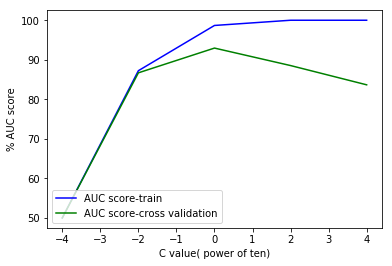

In [41]:
#spliting the test,train,cross-validation data 
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

auc_sc_train=[]
auc_sc_cv=[]
val_C=[]
val=-4
a=0.0
a=(math.pow(10,-4))
for i in range(0,5):
     val_C.append((val))
    
    
     LR_cv = LogisticRegression(penalty='l1',C=a)


    # fitting the model on crossvalidation train
     LR_cv.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
     train_pred = LR_cv.predict_proba(X_tr)
     cv_pred=LR_cv.predict_proba(X_cv)
    
   
    # evaluate CV accuracy
     auc_train=roc_auc_score(y_tr, train_pred[:,1]) * float(100) #taking the probability of 1 
     auc_sc_train.append(auc_train)
     auc_cv=roc_auc_score(y_cv,cv_pred[:,1]) * float(100)
     auc_sc_cv.append(auc_cv)
     print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
     print('\nAuc Score of validation data for C= %d is %d%%' % ((a), auc_cv))
     a=a*100
     val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.plot(val_C,auc_sc_cv,color='g',label="AUC score-cross validation")

plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()


     
    

So from the above graph we can say that optimum vlue of C is approximatey 1 or value of lambda is 1

Now we will choose the optimum hyper parameter using grid search

In [42]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_tr, y_tr)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9429374352906374


So we finalize that the hyperparameter that we will be using is C=1 as obtained by the above algorithms


AUC score for Lambda = 1 is 90%
[[ 7556  5177]
 [ 2684 63579]]


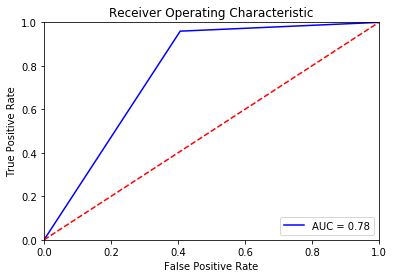

In [43]:
LR=LogisticRegression(penalty='l1',C=1)
LR.fit(X_tr,y_tr)
test_pred_prob=LR.predict_proba(X_test)
test_pred=LR.predict(X_test)
auc_test=roc_auc_score(y_test, test_pred_prob[:,1]) * float(100)
print('\nAUC score for Lambda = %d is %d%%' % ((1, auc_test)))
con_mat=confusion_matrix(y_test,test_pred)
print(con_mat)

fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

So AUC score for L1 regulirazation using C=1 is .90 with area under curve .78 which is decent 


Now we will check the sparsity of L1 regulirazation 

In [45]:
clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(X_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))


186


In [46]:
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(X_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))


7


In [47]:
clf = LogisticRegression(C=1, penalty='l1');
clf.fit(X_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))


1187


In [48]:
clf = LogisticRegression(C=10, penalty='l1');
clf.fit(X_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))


1851


So we notice that as C deccreases(lambda increases) the sparsity increases

In [ ]:
# Please write all the code with proper documentation

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

Now we will LR on L2 regularization


Auc Score of train data for C = 0 is 51%

Auc Score of train data for C = 0 is 94%

Auc Score of train data for C = 1 is 99%

Auc Score of train data for C = 100 is 99%

Auc Score of train data for C = 10000 is 99%


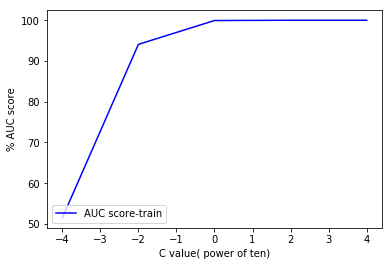

In [49]:
#spliting the test,train,cross-validation data 
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
auc_sc_train=[]
val_C=[]
a=(math.pow(10,-4))
val=-4
for i in range(0,5):
    val_C.append(val)
    LR=LogisticRegression(penalty='l2',C=a)
    LR.fit(X_tr,y_tr)
    train_pred=LR.predict_proba(X_tr)
    auc_train=roc_auc_score(y_tr, train_pred[:,1])* float(100)
    auc_sc_train.append(auc_train)
    print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
    a=a*100
    val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()



In [ ]:
So we find approximately C=1 the optimal hyper parameter 


Auc Score of train data for C = 0 is 71%

Auc Score of validation data for C= 0 is 71%

Auc Score of train data for C = 0 is 94%

Auc Score of validation data for C= 0 is 93%

Auc Score of train data for C = 1 is 99%

Auc Score of validation data for C= 1 is 93%

Auc Score of train data for C = 100 is 99%

Auc Score of validation data for C= 100 is 91%

Auc Score of train data for C = 10000 is 99%

Auc Score of validation data for C= 10000 is 91%


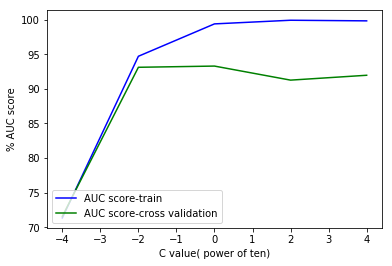

In [50]:
#spliting the test,train,cross-validation data 
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

auc_sc_train=[]
auc_sc_cv=[]
val_C=[]
val=-4
a=0.0
a=(math.pow(10,-4))
for i in range(0,5):
     val_C.append((val))
    
    
     LR_cv = LogisticRegression(penalty='l2',C=a)


    # fitting the model on crossvalidation train
     LR_cv.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
     train_pred = LR_cv.predict_proba(X_tr)
     cv_pred=LR_cv.predict_proba(X_cv)
    
   
    # evaluate CV accuracy
     auc_train=roc_auc_score(y_tr, train_pred[:,1]) * float(100) #taking the probability of 1 
     auc_sc_train.append(auc_train)
     auc_cv=roc_auc_score(y_cv,cv_pred[:,1]) * float(100)
     auc_sc_cv.append(auc_cv)
     print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
     print('\nAuc Score of validation data for C= %d is %d%%' % ((a), auc_cv))
     a=a*100
     val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.plot(val_C,auc_sc_cv,color='g',label="AUC score-cross validation")

plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()


So we find that with C=10^-2 we have a optimal hyperparameter 

In [51]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_tr, y_tr)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9429374352906374


So we will test with 10^-2 and 1 to chech wich is the best hyperparameter


AUC score for Lambda = 0 is 89%
[[ 2878  9855]
 [  633 65630]]


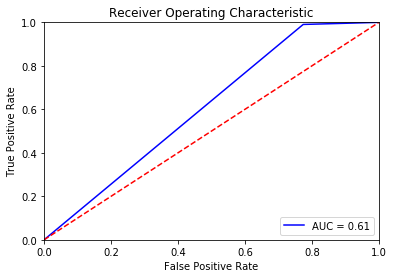

In [52]:
#C=.01
LR=LogisticRegression(penalty='l2',C=0.01)
LR.fit(X_tr,y_tr)
test_pred_prob=LR.predict_proba(X_test)
test_pred=LR.predict(X_test)
auc_test=roc_auc_score(y_test, test_pred_prob[:,1]) * float(100)
print('\nAUC score for Lambda = %d is %d%%' % ((0.01, auc_test)))
con_mat=confusion_matrix(y_test,test_pred)
print(con_mat)

fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


AUC score for Lambda = 1 is 93%
[[ 2843  1385]
 [  850 21254]]


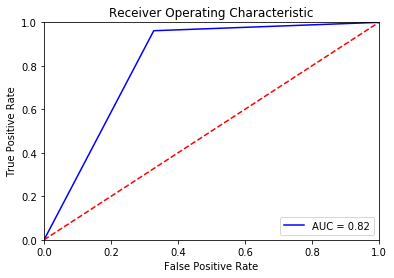

In [129]:
#C=1
#spliting the test,train,cross-validation data 
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

LR=LogisticRegression(penalty='l2',C=1)
LR.fit(X_tr,y_tr)
test_pred_prob=LR.predict_proba(X_test)
test_pred=LR.predict(X_test)
auc_test=roc_auc_score(y_test, test_pred_prob[:,1]) * float(100)
print('\nAUC score for Lambda = %d is %d%%' % ((1, auc_test)))
con_mat=confusion_matrix(y_test,test_pred)
print(con_mat)

fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

So,clearly C=1 is the best hyperparameter.

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [8]:
features=count_vect.get_feature_names()
features

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaaaaaaaa',
 'aaaaaaaaaaaaaaa',
 'aaaaaaahhhhhh',
 'aaaaaaarrrrrggghhh',
 'aaaaaawwwwwwwwww',
 'aaaaah',
 'aaaah',
 'aaaand',
 'aaah',
 'aaahs',
 'aachen',
 'aadp',
 'aaf',
 'aafco',
 'aah',
 'aahhhs',
 'aahing',
 'aahs',
 'aamazon',
 'aap',
 'aarthur',
 'aarti',
 'aasanfood',
 'ab',
 'aback',
 'abandon',
 'abandoned',
 'abandoning',
 'abates',
 'abb',
 'abbaye',
 'abberline',
 'abbey',
 'abbott',
 'abbreviated',
 'abbreviation',
 'abby',
 'abc',
 'abcessed',
 'abd',
 'abdomen',
 'abdominal',
 'abe',
 'abeneficial',
 'aberration',
 'abetter',
 'abhor',
 'abhors',
 'abid',
 'abide',
 'abiding',
 'abig',
 'abilities',
 'ability',
 'abilling',
 'abit',
 'abita',
 'ablaze',
 'able',
 'ablity',
 'ablution',
 'abnormal',
 'abnormalities',
 'abnormality',
 'abnormally',
 'abnoxious',
 'aboard',
 'abode',
 'abolitionists',
 'abolutely',
 'abolutley',
 'abomination',
 'abominations',
 'abondant',
 'aboout',
 'abor',
 'aborio',
 'aboslutely',
 'abosolutly',

In [44]:
X_noi = X
epsilon = np.random.normal(loc=0.0, scale=0.01)
non_zero_index = np.transpose(np.nonzero(X_noi))
print(non_zero_index)
for i,j in non_zero_index:
    
    X_noi[i,j] += epsilon
    

[[    0  2157]
 [    0  3439]
 [    0  6468]
 ...
 [87772 46377]
 [87772 49335]
 [87772 49338]]


In [51]:
X.data=X.data+math.pow(10,-4)

In [52]:
LR=LogisticRegression(penalty='l2',C=1)

LR.fit(X,y)
w_noi=LR.coef_
w_noi


array([[-7.45397124e-02,  5.19054527e-01,  2.02189642e-02, ...,
        -1.33026860e-01,  6.66690847e-05,  1.54047838e-01]])

In [49]:
LR=LogisticRegression(penalty='l2',C=1)
LR.fit(X,y)
w=LR.coef_
w

array([[-7.46446406e-02,  5.18881370e-01,  2.02175497e-02, ...,
        -1.33318901e-01,  6.58122607e-05,  1.54082792e-01]])

In [53]:
change=(abs((w-w_noi)/w)*100).ravel().tolist()
change

[0.1405703200509778,
 0.03337128682728924,
 0.006996417811786663,
 0.2354187369244347,
 2.2399644688598497,
 0.1509820989091999,
 0.756236979217539,
 0.27935086144367943,
 0.756236979217539,
 0.3341565554678018,
 89.583687977692,
 0.09867618751441365,
 1.8819950019583014,
 14.178010367929621,
 0.05046029683001773,
 21.062780633544627,
 3.0485291734052806,
 0.0599959434765082,
 19.027392128578708,
 2.227512117255289,
 0.045836505199676705,
 42.829005392625206,
 0.5852504753111952,
 16.17543817110934,
 2.8157362245344424,
 13.13781624902319,
 0.061339865508571886,
 0.12269445117117793,
 0.09659991476387676,
 0.02560109989921498,
 0.023177429431423854,
 0.042993193020996294,
 0.08189574998151393,
 75.91373824401944,
 79.24174835074432,
 0.026267921242408683,
 0.15323460261222932,
 0.034503734761935495,
 0.014790569740333125,
 261.40166474879953,
 0.011386806372961581,
 0.048006376898053454,
 0.263738274218604,
 0.2552581138718739,
 0.03579777561075418,
 0.007050713831057269,
 0.2494402127

In [82]:

change
print(np.percentile(change,100))

3508.6373269231963


In [56]:
for i in range(0,110,10):
    perc=np.percentile(change,i)
    
    print(perc)

1.9976722844678127e-06
0.009812863334876583
0.02093942245199828
0.03573161579725255
0.057174020909954146
0.08916563095842676
0.14919248268029464
0.27790043437271617
0.6299933274707157
3.9380261149156066
11952.415839772942


So we notice a sudden rise in percentile values from 90 to 100 percentile 

In [59]:
for i in range(90,100,1):
    perc=np.percentile(change,i)
    
    print(perc)

3.9380261149156066
5.300979770263021
7.576838170093391
11.829008269104587
20.62120385495652
36.75016844380371
62.45544936394558
85.6144838221839
89.13986313758349
89.32091275550842


So we notice a suden rise in percentage change between the 99 pecentile and the 100 percentile

In [63]:
for i in np.arange(99,100.1,0.1):
    perc=np.percentile(change,i)
    
    print(perc)

89.32091275550842
89.34316936511955
89.41418179609232
89.59863626423491
89.98776098204623
91.32351890022053
94.1313108468471
100.36130037178914
115.05952027348772
161.52615115506956
11952.415839591233


In [66]:
for i in np.arange(99.95,100,0.01):
    perc=np.percentile(change,i)
    
    print(perc)

402.39704226334095
558.3821440964414
769.3538090326692
1419.2564617028581
2835.423045908313


So we can clearly declare 161.62 as a threshold value 

In [64]:
for i in np.arange(99,100.05,0.05):
    perc=np.percentile(change,i)
    
    print(perc)

89.32091275550842
89.32247775026431
89.34316936511955
89.37442265870231
89.41418179609232
89.45916790587611
89.59863626423491
89.8407531568891
89.98776098204623
90.69143877302078
91.32351890022053
93.01665663601776
94.1313108468471
96.30672037946184
100.36130037178914
104.27066078340843
115.05952027348772
143.80411497819983
161.52615115506956
402.39704226288245
11952.415839591233


In [74]:
#Calculating the percentiles 
for i in np.arange(90,100,0.1):
    perc=np.percentile(change,i)
    if perc>161:
        
        print("The percentile which surpasses the tolerance value is  %d%%"%(i))
        break
   

The percentile which surpasses the tolerance value is  99%


Now we print the features that surpasses the tolerance value 

In [69]:

    

topn_ids = np.argsort(change)[::-1][:]

top_feats = [(features[i], change[i]) for i in topn_ids]
df = pd.DataFrame(top_feats)
df.columns = ['feature', '% Change']
df=df[df["% Change"]>161.62]
df

      

,feature,% Change
0,northerner,11952.415840
1,lineif,5708.950223
2,thirded,3508.546149
3,morrill,3508.546149
4,burnham,3508.546149
5,eiliminated,2923.083140
6,conveyors,2744.294451
7,ceremonies,2744.294451
8,knfe,1958.249166
9,teflon,1958.249166


Therefore we get 54 features with % change more than threshold

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [142]:
# Please write all the code with proper documentation
# now we find the 10 important features with our best fit model with C=1 and l2 regulirazation
w=LR.coef_ # weights of positive class
w

array([[-0.25040814,  0.03932218,  0.01706246, ..., -0.22674681,
         0.        ,  0.        ]])

In [149]:
w_df = (pd.DataFrame(w, columns=features)).T
print("Shape of the dataframe: ", w_df.shape)
w_df_sorted = w_df.sort_values(ascending=False, by=0)

w_df_sorted.reset_index(level=0, inplace=True)
w_df_sorted.columns=["Positive Features","Weight"]
w_df_sorted.head(10)


# Now for negative features
#w_df_sorted = w_df.sort_values(ascending=True, by=0)
#w_df_sorted.head(5)

Shape of the dataframe:  (54904, 1)


,Positive Features,Weight
0,pleasantly,2.698565
1,hooked,2.229114
2,worried,2.126140
3,delicious,2.016180
4,complaint,2.006723
5,beat,1.981878
6,excellent,1.970122
7,wonderful,1.859846
8,awesome,1.858747
9,perfect,1.798584


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [150]:
# Please write all the code with proper documentation
w_df_sorted = w_df.sort_values(ascending=True, by=0)

w_df_sorted.reset_index(level=0, inplace=True)
w_df_sorted.columns=["Negative Features","Weight"]
w_df_sorted.head(10)



,Negative Features,Weight
0,worst,-2.831223
1,disappointing,-2.570466
2,awful,-2.374843
3,tasteless,-2.254554
4,cancelled,-2.236262
5,terrible,-2.195342
6,disappointment,-2.119216
7,undrinkable,-2.102553
8,rip,-2.063977
9,swallowing,-2.037188


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [75]:
X=(final_tf_idf)

y=np.array(final["Score"]) #making the score column of dataframe to numpy array


First we perfom the train test split to find which gives the best AUC Score


Auc Score of train data for C = 0 is 50%

Auc Score of train data for C = 0 is 50%

Auc Score of train data for C = 1 is 93%

Auc Score of train data for C = 100 is 99%

Auc Score of train data for C = 10000 is 99%


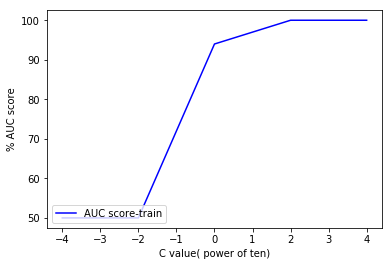

In [157]:
#spliting the test,train,cross-validation data 
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
auc_sc_train=[]
val_C=[]
a=(math.pow(10,-4))
val=-4
for i in range(0,5):
    val_C.append(val)
    LR=LogisticRegression(penalty='l1',C=a)
    LR.fit(X_tr,y_tr)
    train_pred=LR.predict_proba(X_tr)
    auc_train=roc_auc_score(y_tr, train_pred[:,1])* float(100)
    auc_sc_train.append(auc_train)
    print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
    a=a*100
    val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()


So we find the the highest AUC score lies in Approximately 10^2 


Auc Score of train data for C = 0 is 50%

Auc Score of validation data for C= 0 is 50%

Auc Score of train data for C = 0 is 66%

Auc Score of validation data for C= 0 is 67%

Auc Score of train data for C = 1 is 96%

Auc Score of validation data for C= 1 is 95%

Auc Score of train data for C = 100 is 99%

Auc Score of validation data for C= 100 is 95%

Auc Score of train data for C = 10000 is 99%

Auc Score of validation data for C= 10000 is 94%


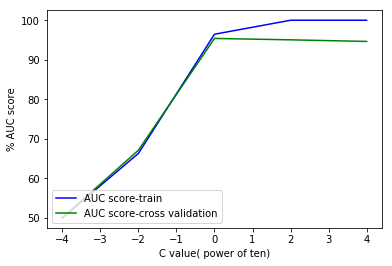

In [158]:
#spliting the test,train,cross-validation data 
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

auc_sc_train=[]
auc_sc_cv=[]
val_C=[]
val=-4
a=0.0
a=(math.pow(10,-4))
for i in range(0,5):
     val_C.append((val))
    
    
     LR_cv = LogisticRegression(penalty='l1',C=a)


    # fitting the model on crossvalidation train
     LR_cv.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
     train_pred = LR_cv.predict_proba(X_tr)
     cv_pred=LR_cv.predict_proba(X_cv)
    
   
    # evaluate CV accuracy
     auc_train=roc_auc_score(y_tr, train_pred[:,1]) * float(100) #taking the probability of 1 
     auc_sc_train.append(auc_train)
     auc_cv=roc_auc_score(y_cv,cv_pred[:,1]) * float(100)
     auc_sc_cv.append(auc_cv)
     print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
     print('\nAuc Score of validation data for C= %d is %d%%' % ((a), auc_cv))
     a=a*100
     val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.plot(val_C,auc_sc_cv,color='g',label="AUC score-cross validation")

plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()


USing cross validation data ,we get c value to be 1 which might be the optimal hyperparameter

In [159]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_tr, y_tr)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9500720821442231


So C=10000 is the best hyperparameter with regulirazation of l2 

In [160]:
#sparsity test 

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(X_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))




4


In [162]:
clf = LogisticRegression(C=10, penalty='l1');
clf.fit(X_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))


1543


In [161]:
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(X_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))


0


so we can clearly see that as C decreases,lambda increases and sparsity increases 

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

# Please write all the code with proper documentation
Since we knw the best model lis with l2 regularizer with C=10000 we directly fit the train data in there and get our test results


AUC score for Lambda = 0 is 94%
[[ 7624  5109]
 [ 1679 64584]]


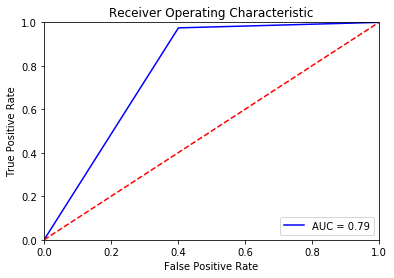

In [163]:
LR=LogisticRegression(penalty='l2',C=10000)
LR.fit(X_tr,y_tr)
test_pred_prob=LR.predict_proba(X_test)
test_pred=LR.predict(X_test)
auc_test=roc_auc_score(y_test, test_pred_prob[:,1]) * float(100)
print('\nAUC score for Lambda = %d is %d%%' % ((.0001, auc_test)))
con_mat=confusion_matrix(y_test,test_pred)
print(con_mat)

fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

So we get a AuC score of 94% and Area under curve of .79 which is decent 

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [170]:
# Please write all the code with proper documentation
w=LR.coef_ # weights of positive class
w
w_df = (pd.DataFrame(w, columns=features_tfidf)).T

w_df_sorted = w_df.sort_values(ascending=False, by=0)

w_df_sorted.reset_index(level=0, inplace=True)
w_df_sorted.columns=["Positive Features","Weight"]
w_df_sorted.head(10)


,Positive Features,Weight
0,great,34.910622
1,best,30.665569
2,delicious,30.309137
3,good,29.180129
4,wonderful,23.259348
5,excellent,22.503886
6,love,22.192692
7,amazing,20.969533
8,perfect,20.132808
9,loves,19.228874


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [171]:
# Please write all the code with proper documentation
w_df_sorted = w_df.sort_values(ascending=True, by=0)

w_df_sorted.reset_index(level=0, inplace=True)
w_df_sorted.columns=["Negative Features","Weight"]
w_df_sorted.head(10)

,Negative Features,Weight
0,worst,-29.748703
1,not,-24.887105
2,not worth,-24.607073
3,disappointed,-23.314046
4,horrible,-22.669702
5,unfortunately,-20.872328
6,disappointing,-20.413500
7,not recommend,-20.017557
8,not order,-19.046432
9,not buy,-18.591710


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [172]:
# Please write all the code with proper documentation
with open('AVGW2V.pkl', 'rb') as f:
    sent_vectors=pickle.load(f)
    

In [173]:
X=(sent_vectors)

y=np.array(final["Score"]) #making the score column of dataframe to numpy array



Auc Score of train data for C = 0 is 50%

Auc Score of train data for C = 0 is 87%

Auc Score of train data for C = 1 is 91%

Auc Score of train data for C = 100 is 91%

Auc Score of train data for C = 10000 is 91%


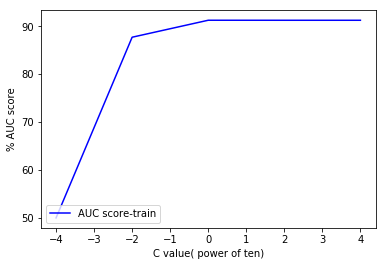

In [174]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
auc_sc_train=[]
val_C=[]
a=(math.pow(10,-4))
val=-4
for i in range(0,5):
    val_C.append(val)
    LR=LogisticRegression(penalty='l1',C=a)
    LR.fit(X_tr,y_tr)
    train_pred=LR.predict_proba(X_tr)
    auc_train=roc_auc_score(y_tr, train_pred[:,1])* float(100)
    auc_sc_train.append(auc_train)
    print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
    a=a*100
    val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()


Auc Score of train data for C = 0 is 56%

Auc Score of validation data for C= 0 is 55%

Auc Score of train data for C = 0 is 90%

Auc Score of validation data for C= 0 is 90%

Auc Score of train data for C = 1 is 90%

Auc Score of validation data for C= 1 is 90%

Auc Score of train data for C = 100 is 90%

Auc Score of validation data for C= 100 is 90%

Auc Score of train data for C = 10000 is 90%

Auc Score of validation data for C= 10000 is 90%


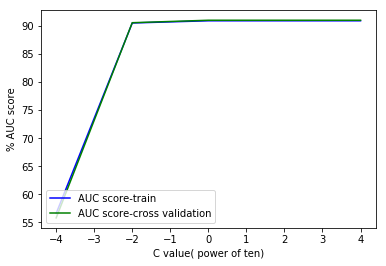

In [175]:
#spliting the test,train,cross-validation data 
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

auc_sc_train=[]
auc_sc_cv=[]
val_C=[]
val=-4
a=0.0
a=(math.pow(10,-4))
for i in range(0,5):
     val_C.append((val))
    
    
     LR_cv = LogisticRegression(penalty='l1',C=a)


    # fitting the model on crossvalidation train
     LR_cv.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
     train_pred = LR_cv.predict_proba(X_tr)
     cv_pred=LR_cv.predict_proba(X_cv)
    
   
    # evaluate CV accuracy
     auc_train=roc_auc_score(y_tr, train_pred[:,1]) * float(100) #taking the probability of 1 
     auc_sc_train.append(auc_train)
     auc_cv=roc_auc_score(y_cv,cv_pred[:,1]) * float(100)
     auc_sc_cv.append(auc_cv)
     print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
     print('\nAuc Score of validation data for C= %d is %d%%' % ((a), auc_cv))
     a=a*100
     val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.plot(val_C,auc_sc_cv,color='g',label="AUC score-cross validation")

plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()


We see that train and cross validation data merges which is absurd!

In [176]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_tr, y_tr)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9354262191816942


So we find that with C=1 and l2 regulirazation we might get the best model

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>


Auc Score of train data for C = 0 is 69%

Auc Score of train data for C = 0 is 90%

Auc Score of train data for C = 1 is 91%

Auc Score of train data for C = 100 is 91%

Auc Score of train data for C = 10000 is 91%


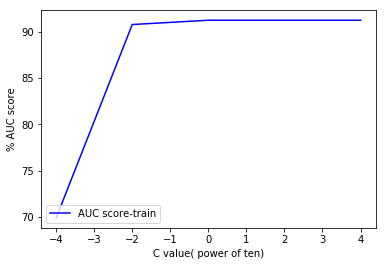

In [178]:
# Please write all the code with proper documentation
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
auc_sc_train=[]
val_C=[]
a=(math.pow(10,-4))
val=-4
for i in range(0,5):
    val_C.append(val)
    LR=LogisticRegression(penalty='l2',C=a)
    LR.fit(X_tr,y_tr)
    train_pred=LR.predict_proba(X_tr)
    auc_train=roc_auc_score(y_tr, train_pred[:,1])* float(100)
    auc_sc_train.append(auc_train)
    print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
    a=a*100
    val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()


Auc Score of train data for C = 0 is 81%

Auc Score of validation data for C= 0 is 82%

Auc Score of train data for C = 0 is 90%

Auc Score of validation data for C= 0 is 91%

Auc Score of train data for C = 1 is 90%

Auc Score of validation data for C= 1 is 91%

Auc Score of train data for C = 100 is 90%

Auc Score of validation data for C= 100 is 91%

Auc Score of train data for C = 10000 is 90%

Auc Score of validation data for C= 10000 is 91%


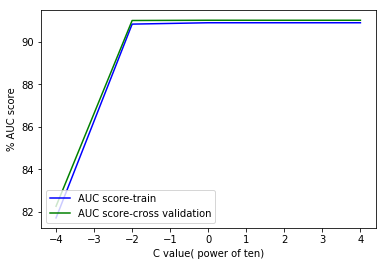

In [179]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

auc_sc_train=[]
auc_sc_cv=[]
val_C=[]
val=-4
a=0.0
a=(math.pow(10,-4))
for i in range(0,5):
     val_C.append((val))
    
    
     LR_cv = LogisticRegression(penalty='l2',C=a)


    # fitting the model on crossvalidation train
     LR_cv.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
     train_pred = LR_cv.predict_proba(X_tr)
     cv_pred=LR_cv.predict_proba(X_cv)
    
   
    # evaluate CV accuracy
     auc_train=roc_auc_score(y_tr, train_pred[:,1]) * float(100) #taking the probability of 1 
     auc_sc_train.append(auc_train)
     auc_cv=roc_auc_score(y_cv,cv_pred[:,1]) * float(100)
     auc_sc_cv.append(auc_cv)
     print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
     print('\nAuc Score of validation data for C= %d is %d%%' % ((a), auc_cv))
     a=a*100
     val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.plot(val_C,auc_sc_cv,color='g',label="AUC score-cross validation")

plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()


We find that even with L2 regularization train and cross validation trend is almost the same 

So we fit the model with C=1 along with L2 regularizer


AUC score for Lambda = 0 is 90%
[[ 2113  2115]
 [  760 21344]]


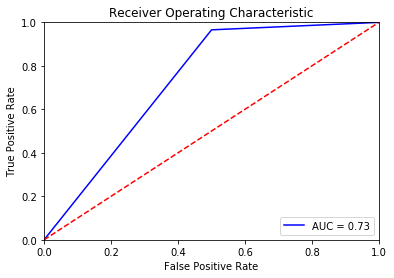

In [180]:
LR=LogisticRegression(penalty='l2',C=1)
LR.fit(X_tr,y_tr)
test_pred_prob=LR.predict_proba(X_test)
test_pred=LR.predict(X_test)
auc_test=roc_auc_score(y_test, test_pred_prob[:,1]) * float(100)
print('\nAUC score for Lambda = %d is %d%%' % ((.0001, auc_test)))
con_mat=confusion_matrix(y_test,test_pred)
print(con_mat)

fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

So,AUC score is 90 % and area under curve is .73 which is decent 

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [206]:
# Please write all the code with proper documentation

with open('TFIDFWV.pkl', 'rb') as f:
    tfidf_sent_vectors=pickle.load(f)
    

In [207]:
X=(tfidf_sent_vectors)

y=np.array(final["Score"]) #making the score column of dataframe to numpy array



Auc Score of train data for C = 0 is 50%

Auc Score of train data for C = 0 is 85%

Auc Score of train data for C = 1 is 89%

Auc Score of train data for C = 100 is 89%

Auc Score of train data for C = 10000 is 89%


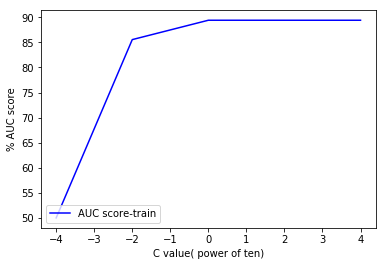

In [208]:
#spliting the test,train,cross-validation data 
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
auc_sc_train=[]
val_C=[]
a=(math.pow(10,-4))
val=-4
for i in range(0,5):
    val_C.append(val)
    LR=LogisticRegression(penalty='l1',C=a)
    LR.fit(X_tr,y_tr)
    train_pred=LR.predict_proba(X_tr)
    auc_train=roc_auc_score(y_tr, train_pred[:,1])* float(100)
    auc_sc_train.append(auc_train)
    print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
    a=a*100
    val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()



Auc Score of train data for C = 0 is 50%

Auc Score of validation data for C= 0 is 50%

Auc Score of train data for C = 0 is 88%

Auc Score of validation data for C= 0 is 87%

Auc Score of train data for C = 1 is 89%

Auc Score of validation data for C= 1 is 88%

Auc Score of train data for C = 100 is 89%

Auc Score of validation data for C= 100 is 88%

Auc Score of train data for C = 10000 is 89%

Auc Score of validation data for C= 10000 is 88%


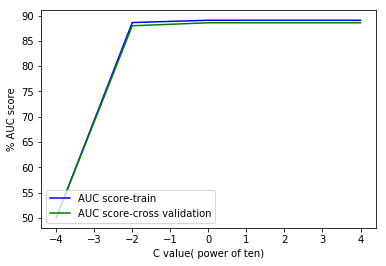

In [209]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

auc_sc_train=[]
auc_sc_cv=[]
val_C=[]
val=-4
a=0.0
a=(math.pow(10,-4))
for i in range(0,5):
     val_C.append((val))
    
    
     LR_cv = LogisticRegression(penalty='l1',C=a)


    # fitting the model on crossvalidation train
     LR_cv.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
     train_pred = LR_cv.predict_proba(X_tr)
     cv_pred=LR_cv.predict_proba(X_cv)
    
   
    # evaluate CV accuracy
     auc_train=roc_auc_score(y_tr, train_pred[:,1]) * float(100) #taking the probability of 1 
     auc_sc_train.append(auc_train)
     auc_cv=roc_auc_score(y_cv,cv_pred[:,1]) * float(100)
     auc_sc_cv.append(auc_cv)
     print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
     print('\nAuc Score of validation data for C= %d is %d%%' % ((a), auc_cv))
     a=a*100
     val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.plot(val_C,auc_sc_cv,color='g',label="AUC score-cross validation")

plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()


In [210]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_tr, y_tr)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9302691366655015


So the best estimator is C=100 with l2 regularizer 

[5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V, SET 4¶

Now we do the model fit with L2 regularizer


Auc Score of train data for C = 0 is 68%

Auc Score of train data for C = 0 is 88%

Auc Score of train data for C = 1 is 89%

Auc Score of train data for C = 100 is 89%

Auc Score of train data for C = 10000 is 89%


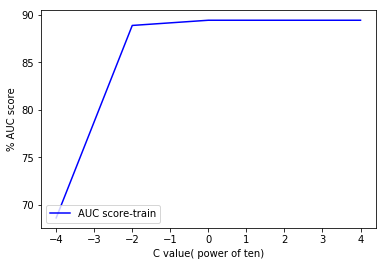

In [211]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
auc_sc_train=[]
val_C=[]
a=(math.pow(10,-4))
val=-4
for i in range(0,5):
    val_C.append(val)
    LR=LogisticRegression(penalty='l2',C=a)
    LR.fit(X_tr,y_tr)
    train_pred=LR.predict_proba(X_tr)
    auc_train=roc_auc_score(y_tr, train_pred[:,1])* float(100)
    auc_sc_train.append(auc_train)
    print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
    a=a*100
    val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()



Auc Score of train data for C = 0 is 79%

Auc Score of validation data for C= 0 is 78%

Auc Score of train data for C = 0 is 88%

Auc Score of validation data for C= 0 is 88%

Auc Score of train data for C = 1 is 89%

Auc Score of validation data for C= 1 is 88%

Auc Score of train data for C = 100 is 89%

Auc Score of validation data for C= 100 is 88%

Auc Score of train data for C = 10000 is 89%

Auc Score of validation data for C= 10000 is 88%


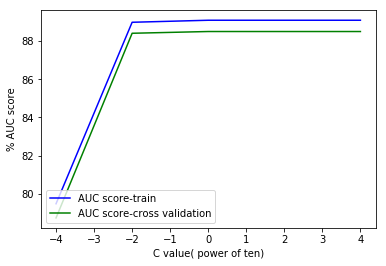

In [214]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

auc_sc_train=[]
auc_sc_cv=[]
val_C=[]
val=-4
a=0.0
a=(math.pow(10,-4))
for i in range(0,5):
     val_C.append((val))
    
    
     LR_cv = LogisticRegression(penalty='l2',C=a)


    # fitting the model on crossvalidation train
     LR_cv.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
     train_pred = LR_cv.predict_proba(X_tr)
     cv_pred=LR_cv.predict_proba(X_cv)
    
   
    # evaluate CV accuracy
     auc_train=roc_auc_score(y_tr, train_pred[:,1]) * float(100) #taking the probability of 1 
     auc_sc_train.append(auc_train)
     auc_cv=roc_auc_score(y_cv,cv_pred[:,1]) * float(100)
     auc_sc_cv.append(auc_cv)
     print('\nAuc Score of train data for C = %d is %d%%' % ((a), auc_train))
     print('\nAuc Score of validation data for C= %d is %d%%' % ((a), auc_cv))
     a=a*100
     val=val+2
plt.plot(val_C,auc_sc_train,color='b',label="AUC score-train")
plt.plot(val_C,auc_sc_cv,color='g',label="AUC score-cross validation")

plt.xlabel("C value( power of ten)")
plt.ylabel("% AUC score")
pylab.legend(loc='lower left')



plt.show()


So best value of C lies approximately is  10^-1

Since we know that best model lies with C=100 and l2 regulirizer we will try to get results with that


AUC score for Lambda = 0 is 88%
[[ 1804  2424]
 [  734 21370]]


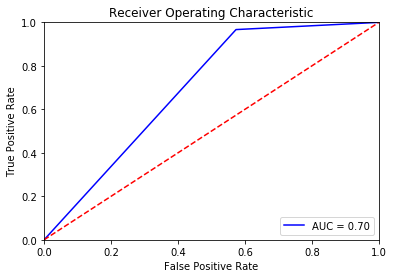

In [218]:
LR=LogisticRegression(penalty='l2',C=100)
LR.fit(X_tr,y_tr)
test_pred_prob=LR.predict_proba(X_test)
test_pred=LR.predict(X_test)
auc_test=roc_auc_score(y_test, test_pred_prob[:,1]) * float(100)
print('\nAUC score for Lambda = %d is %d%%' % ((.01, auc_test)))
con_mat=confusion_matrix(y_test,test_pred)
print(con_mat)

fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We get AUC score to be 88% and area under curve is 0.70 which is decent

# [6] Conclusions

In [220]:
# Please compare all your models using Prettytable library
x=PrettyTable()
x.field_names=["Methodology","Algorithm","C-Value","Regularizer","AUC Score","Area under curve"]
x.add_row(["BOW","Multinomial LR",1,"L2-regularizer","93%","0.82"])
x.add_row(["TF-IDF","Multinomial LR",10000,"L2-regularizer","94%","0.79"])
x.add_row(["AVGw2V","Multinomial LR",1,"L2-regularizer","90%","0.73"])
x.add_row(["TF_IDF_W2V","Multinomial LR",100,"L2-regularizer","88%","0.70"])
print(x)

+-------------+----------------+---------+----------------+-----------+------------------+
| Methodology |   Algorithm    | C-Value |  Regularizer   | AUC Score | Area under curve |
+-------------+----------------+---------+----------------+-----------+------------------+
|     BOW     | Multinomial LR |    1    | L2-regularizer |    93%    |       0.82       |
|    TF-IDF   | Multinomial LR |  10000  | L2-regularizer |    94%    |       0.79       |
|    AVGw2V   | Multinomial LR |    1    | L2-regularizer |    90%    |       0.73       |
|  TF_IDF_W2V | Multinomial LR |   100   | L2-regularizer |    88%    |       0.70       |
+-------------+----------------+---------+----------------+-----------+------------------+
